In [6]:
# This notebook computes and plots the results for Table 2 in the paper and a few more that were
# not included in the interest of space (results using temperature scaling and histogram binning, 
# for the binary cases).

import matplotlib.pyplot as plt
import numpy as np
from expected_cost import ec, utils
from expected_cost.data import get_llks_for_multi_classif_task
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, recall_score, precision_score
from expected_cost.calibration import calibration_with_crossval, calibration_train_on_test
from expected_cost.psrcal_wrappers import Brier, LogLoss, LogLossSE, ECE, ECEbin, L2ECEbin, CalLoss
from psrcal.calibration import HistogramBinningCal
import re
from psrcal.losses import plot_reliability_diagram

outdir = "outputs/"
utils.mkdir_p(outdir)

In [7]:
data_dir = '../data/'

datasets = {
            'SST2 GPT2-4sh':         'sst2_gpt2_4shot',
            'SST2 GPT2-0sh':         'sst2_gpt2',
            'SITW XvPLDA':           'sitw_plda',
            'FVCAUS XvPLDA':         'fvcaus_plda',
            'CIFAR-1vsO Resnet-20': ('cifar100_resnet-20/', None, 1),
            'CIFAR-2vsO Resnet-20': ('cifar100_resnet-20/', None, 2),
            'PNEUM Resnet-50':       'pneumoniamnist_resnet50',
            'ADRENAL Resnet-50': 'adrenalmnist_resnet50',
            'PATH Resnet-50':        'pathmnist_resnet50',
            'IEMOCAP W2V2':          'iemocap_wav2vec_pt',
            'AGNEWS GPT2-0sh':       'agnews_gpt2',
            'CIFAR10 Resnet-20':     'cifar10_resnet-20/',
            'CIFAR10 Vgg19':         'cifar10_vgg19_bn/',
            'CIFAR10 RepVgg-a2':     'cifar10_repvgg_a2/',
            'CIFAR100 Resnet-20':    'cifar100_resnet-20/',
            'CIFAR100 Vgg19':        'cifar100_vgg19_bn/',
            'CIFAR100 RepVgg-a2':    'cifar100_repvgg_a2/'}

# Field separators for printing to screen or in latex format for the paper
print_style =  '' #'latex'

if print_style == 'latex':
    sep = ' & '
    sep2 = ''
    newline = '\\\\'
else:
    sep = '  ' 
    sep2 = '|' 
    newline = ''

first = True
targets_dict = {}
seed = 0

for dname, dinfo in datasets.items():
    
    data_name = re.sub(' .*','',dname)
    system_name = re.sub('.* ','',dname)

    if type(dinfo) == tuple:
        (dpath, priors, one_vs_other) = dinfo
        targets, logpost_raw, _ = get_llks_for_multi_classif_task(data_dir+dpath, logpost=True, priors=priors, one_vs_other=one_vs_other)
    else:
        dpath = dinfo
        targets, logpost_raw, _ = get_llks_for_multi_classif_task(data_dir+dpath, logpost=True)
    
    targets_dict[dname] = targets

    K = logpost_raw.shape[1]
    counts = np.bincount(targets)
    priors = counts/len(targets)

    # Obtain three calibrated versions
    logpost_dict = {'raw': logpost_raw}
    logpost_dict['calt'] = calibration_with_crossval(logpost_raw, targets, seed=seed, calparams={'bias':False})
    logpost_dict['cal'] = calibration_with_crossval(logpost_raw, targets, seed=seed, calparams={'bias':True})
    if K == 2:
        logpost_dict['calh'] = calibration_with_crossval(logpost_raw, targets, calmethod=HistogramBinningCal, calparams={'M':10})
        logpost_dict['calp'] = calibration_train_on_test(logpost_raw, targets, calmethod='PAV')

    # Define various costs matrices
    costs = {}

    # Standard 0-1 cost
    costs['C01'] = ec.CostMatrix.zero_one_costs(K)

    # Cost with abstain decision
    costs['Cab'] = ec.CostMatrix.zero_one_costs(K, abstention_cost=0.1)

    # Imbalanced cost
    m = costs['C01'].get_matrix().copy()
    m[K-1,:] = 10
    m[K-1,K-1] = 0
    costs['Cimb']  = ec.CostMatrix(m)

    if print_style != 'latex':
        if first is True:
            print(f'\nSystem                         {sep} {sep2} ', end='')
            for costn, cost in costs.items():
                print(f" {costn:5s}{sep} ", end='')
            print(f'{sep2}     CE  {sep} {sep2}  RCL   {sep} ECEmc  {sep} ECEbin {newline}')
            
            first = False
    else:
        print('\\multirow{2}{*}{%s} %s \\multirow{2}{*}{%s}'%(data_name, sep, system_name), end='')

    ce_raw = LogLoss(logpost_raw, targets)

    for logpostname, logpost in logpost_dict.items():

        if print_style != 'latex':
            print(f'{dname:25s}{logpostname:5s} {sep} {sep2} ', end='')
        else:
            if logpostname != 'raw':
                print(f' {sep} ', end='')
            print(f' {sep} {logpostname} {sep}', end='')
        
        

        for costn, cost in costs.items():
            decisions, _ = ec.bayes_decisions(logpost, cost, score_type='log_posteriors')
            ecvaln = ec.average_cost(targets, decisions, cost, adjusted=True)
            print(f"  {ecvaln:5.3f}{sep}", end='')

        ce = LogLoss(logpost, targets)

        # Finally, compute two calibration metrics
        logpost_cal_axv = calibration_with_crossval(logpost, targets, seed=seed, calparams={'bias':True})
        rcl = CalLoss(LogLoss, logpost, logpost_cal_axv, targets, relative=True)
        ece = ECE(logpost, targets)
        if K==2:
            ecebin = ECEbin(logpost, targets)
        
        print(f"{sep2}   {ce:5.3f}  {sep}", end='')

        if K==2:
            print(f"{sep2} {rcl:5.1f} {sep}  {ece:5.1f} {sep} {ecebin:5.1f}  ", end='')
        else:
            print(f"{sep2} {rcl:5.1f} {sep}  {ece:5.1f} {sep}  -  ", end='')

        print(f'{newline}')
    
    if print_style == 'latex':
        print("\\midrule")
    else:
        print("")





System                            |  C01      Cab      Cimb    |     CE     |  RCL      ECEmc     ECEbin 
SST2 GPT2-4sh            raw      |   0.996    0.812    1.000  |   1.073    |  62.4      34.4     34.8  
SST2 GPT2-4sh            calt     |   0.996    1.000    1.000  |   0.931    |  56.4      31.5     31.9  
SST2 GPT2-4sh            cal      |   0.226    0.585    0.711  |   0.404    |  -0.6       1.6      2.2  
SST2 GPT2-4sh            calh     |   0.251    0.691    0.764  |   0.471    |   nan       0.0      0.0  
SST2 GPT2-4sh            calp     |   0.223    0.555    0.660  |   0.385    |  -0.4       0.0      0.0  

SST2 GPT2-0sh            raw      |   0.828    0.818    1.000  |   0.917    |  46.0      20.0     27.3  
SST2 GPT2-0sh            calt     |   0.828    0.995    1.000  |   0.858    |  42.1      18.9     26.9  
SST2 GPT2-0sh            cal      |   0.310    0.655    0.685  |   0.495    |  -0.6       1.4      1.5  
SST2 GPT2-0sh            calh     |   0.307    0.669

[0.14492753 0.2601626  0.30025446 0.3501326  0.42755345 0.5217391
 0.5634744  0.66049385 0.7002652  0.943748  ]


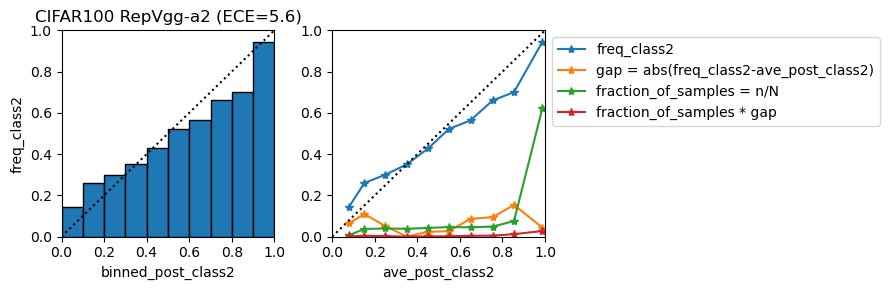

In [8]:

M = 10 # number of bins
    
metric_value, ys, xs, counts, limits = ECE(logpost_raw, targets, return_values=True, M=M)
plot_reliability_diagram(ys, xs, counts, limits, title=dname, figsize=(9,3))
print(ys)